In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Using the SpECTRE Python bindings

This notebook walks you through some of SpECTRE's Python bindings. We will use the TOV solution implemented in SpECTRE to compute the mass profile of a star.

1. Load the Python modules:

In [2]:
import spectre.PointwiseFunctions.AnalyticSolutions.GeneralRelativity as spectre_gr
import spectre.PointwiseFunctions.Hydro.EquationsOfState as spectre_eos

2. Construct an equation of state:

In [3]:
eos = spectre_eos.RelativisticPolytropicFluid(polytropic_constant=8, polytropic_exponent=2)

3. Construct a TOV star with central mass-density $\rho_\mathrm{c}=10^{-3}$ and the equation of state:

In [4]:
tov = spectre_gr.Tov(equation_of_state=eos, central_mass_density=1e-3)

4. Output the star's radius and total mass:

In [5]:
R = tov.outer_radius()
M = tov.mass(R)
R, M

(3.4685521334560225, 0.05310369405512771)

5. Plot the star's mass profile:

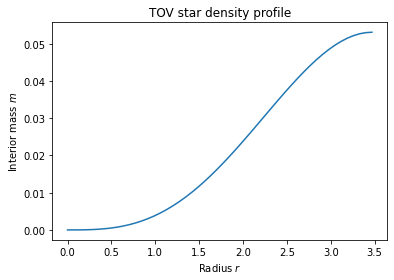

In [6]:
r = np.linspace(0, R)
m = tov.mass(r)

plt.title("TOV star density profile")
plt.plot(r, m)
plt.xlabel(r"Radius $r$")
plt.ylabel(r"Interior mass $m$");